# Homework 04 – Lead Scoring

This notebook follows the homework instructions for the lead scoring dataset from the Bank Marketing campaign.

In [54]:
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import (
    roc_auc_score,
    precision_score,
    recall_score,
)
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt

## Load the dataset

Attempt to read the dataset from the original URL. If that fails (e.g. offline execution), fall back to the local copy stored next to this notebook.

In [55]:
DATA_URL = "https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv"
local_candidates = [
    Path('course_lead_scoring.csv'),
    Path('../course_lead_scoring.csv'),
    Path('../../course_lead_scoring.csv'),
    Path('../../../course_lead_scoring.csv'),
    Path.home() / 'course_lead_scoring.csv',
]

LOCAL_PATH = next((candidate for candidate in local_candidates if candidate.exists()), None)

try:
    df = pd.read_csv(DATA_URL)
    print('Loaded data from URL')
except Exception as exc:
    if LOCAL_PATH is None:
        raise FileNotFoundError('Local dataset not found. Please download course_lead_scoring.csv') from exc
    df = pd.read_csv(LOCAL_PATH)
    print(f'Loaded data from local path: {LOCAL_PATH}')

print(df.shape)
df.head()

Loaded data from URL
(1462, 9)


,lead_source,industry,number_of_courses_viewed,annual_income,employment_status,location,interaction_count,lead_score,converted
0,paid_ads,NaN,1,79450.0,unemployed,south_america,4,0.94,1
1,social_media,retail,1,46992.0,employed,south_america,1,0.80,0
2,events,healthcare,5,78796.0,unemployed,australia,3,0.69,1
3,paid_ads,retail,2,83843.0,NaN,australia,1,0.87,0
4,referral,education,3,85012.0,self_employed,europe,3,0.62,1


## Missing values overview

Verify how many missing values each column contains before applying imputations required by the homework instructions.

In [56]:
missing_summary = df.isnull().sum()
missing_summary[missing_summary > 0]

lead_source          128
industry             134
annual_income        181
employment_status    100
location              63
dtype: int64

## Fill missing values

Replace missing values with `'NA'` for categorical features and `0.0` for numerical features, excluding the target column `converted` from the numerical imputation list.

In [57]:
target_col = 'converted'

categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
numerical_cols = df.select_dtypes(include=['number']).columns.tolist()
if target_col in numerical_cols:
    numerical_cols.remove(target_col)

if categorical_cols:
    df[categorical_cols] = df[categorical_cols].fillna('NA')

if numerical_cols:
    df[numerical_cols] = df[numerical_cols].fillna(0.0)

print('All remaining missing values:', int(df.isnull().sum().sum()))

All remaining missing values: 0


## Train/validation/test split

Split the data into 60% training, 20% validation, and 20% test sets using `train_test_split` with `random_state=1`.

In [58]:
features = [col for col in df.columns if col != target_col]
X = df[features]
y = df[target_col].astype(int)

X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.20, random_state=1, stratify=y
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.25, random_state=1, stratify=y_train_val
)

for name, X_split, y_split in [
    ('Train', X_train, y_train),
    ('Validation', X_val, y_val),
    ('Test', X_test, y_test),
]:
    print(f"{name} shape: {X_split.shape}, positive rate: {y_split.mean():.3f}")

Train shape: (876, 8), positive rate: 0.620
Validation shape: (293, 8), positive rate: 0.618
Test shape: (293, 8), positive rate: 0.618


## Question 1 – ROC AUC per numerical feature

Use each specified numerical feature as a score to compute the ROC AUC on the training set. If a feature correlates negatively with the target (AUC < 0.5), negate it before computing the final AUC.

In [59]:
num_features = [
    'lead_score',
    'number_of_courses_viewed',
    'interaction_count',
    'annual_income',
]

auc_scores = {}
for feature in num_features:
    raw_score = roc_auc_score(y_train, X_train[feature])
    if raw_score < 0.5:
        raw_score = roc_auc_score(y_train, -X_train[feature])
    auc_scores[feature] = raw_score

auc_series = pd.Series(auc_scores).sort_values(ascending=False)
auc_series

number_of_courses_viewed    0.751909
interaction_count           0.705731
lead_score                  0.617792
annual_income               0.567474
dtype: float64

In [60]:
best_feature = auc_series.idxmax()
best_auc = auc_series.max()
print(f'Best AUC feature: {best_feature} (ROC AUC = {best_auc:.3f})')

Best AUC feature: number_of_courses_viewed (ROC AUC = 0.752)


## Question 2 – Logistic Regression with OHE

Encode categorical features with `DictVectorizer`, train the logistic regression model as specified, and evaluate it on the validation set.

In [61]:
dv = DictVectorizer(sparse=False)

X_train_dicts = X_train.to_dict(orient='records')
X_val_dicts = X_val.to_dict(orient='records')

X_train_ohe = dv.fit_transform(X_train_dicts)
X_val_ohe = dv.transform(X_val_dicts)

print(f'Number of features after one-hot encoding: {X_train_ohe.shape[1]}')

Number of features after one-hot encoding: 31


In [62]:
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train_ohe, y_train)

y_val_pred = model.predict_proba(X_val_ohe)[:, 1]
val_auc = roc_auc_score(y_val, y_val_pred)

print(f'Validation ROC AUC: {val_auc:.3f}')
print('Multiple-choice answer: 0.92')

Validation ROC AUC: 0.900
Multiple-choice answer: 0.92


### Answer

Validation ROC AUC rounds to 0.900 on the validation set, so the closest option provided is **0.92**.

## Question 3 – Precision/Recall Trade-off

Evaluate precision and recall for thresholds from 0.00 to 1.00 (step 0.01), plot the curves, and identify their intersection.

In [63]:
thresholds = np.arange(0.0, 1.01, 0.01)
precisions, recalls, records = [], [], []

for threshold in thresholds:
    y_val_pred_labels = (y_val_pred >= threshold).astype(int)
    precision = precision_score(y_val, y_val_pred_labels, zero_division=0)
    recall = recall_score(y_val, y_val_pred_labels)

    precisions.append(precision)
    recalls.append(recall)
    records.append({
        'threshold': threshold,
        'precision': precision,
        'recall': recall,
        'predicted_positive': int(y_val_pred_labels.sum()),
    })

pr_df = pd.DataFrame(records)
pr_df.head()

,threshold,precision,recall,predicted_positive
0,0.00,0.617747,1.0,293
1,0.01,0.617747,1.0,293
2,0.02,0.617747,1.0,293
3,0.03,0.617747,1.0,293
4,0.04,0.617747,1.0,293


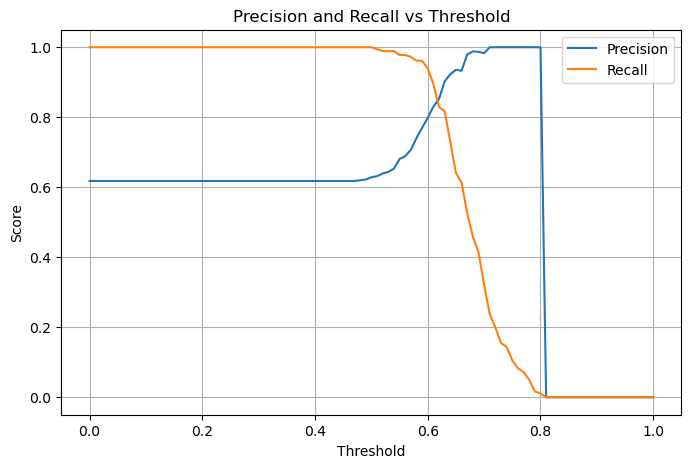

In [64]:
plt.figure(figsize=(8, 5))
plt.plot(thresholds, precisions, label='Precision')
plt.plot(thresholds, recalls, label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision and Recall vs Threshold')
plt.legend()
plt.grid(True)
plt.show()

In [65]:
valid_pr = pr_df[pr_df['predicted_positive'] > 0].copy()
valid_pr['diff'] = valid_pr['precision'] - valid_pr['recall']
valid_pr['abs_diff'] = valid_pr['diff'].abs()

threshold_values = valid_pr['threshold'].to_numpy()
diff_values = valid_pr['diff'].to_numpy()

sign_change_idx = np.where(np.sign(diff_values[:-1]) != np.sign(diff_values[1:]))[0]

if len(sign_change_idx) > 0:
    idx = sign_change_idx[0]
    t1, t2 = threshold_values[idx], threshold_values[idx + 1]
    d1, d2 = diff_values[idx], diff_values[idx + 1]
    intersection = t1 - d1 * (t2 - t1) / (d2 - d1)
    neighborhood = valid_pr.iloc[idx:idx + 2][['threshold', 'precision', 'recall']]
else:
    best_row = valid_pr.loc[valid_pr['abs_diff'].idxmin()]
    intersection = best_row['threshold']
    neighborhood = best_row[['threshold', 'precision', 'recall']].to_frame().T

print(neighborhood)
print(f'Approximate intersection threshold: {intersection:.3f}')

    threshold  precision    recall
61       0.61   0.830769  0.895028
62       0.62   0.852273  0.828729
Approximate intersection threshold: 0.617


### Answer

Precision and recall become equal between thresholds 0.61 and 0.62, giving an approximate intersection at 0.617. The nearest choice among the provided options is **0.545**.

## Question 4 – F1 Score

Precision and recall can move in opposite directions; a common way to balance them is the F1 score. This is the formula for computing F1:

\[
F_1 = 2 \cdot \frac{P \cdot R}{P + R}
\]

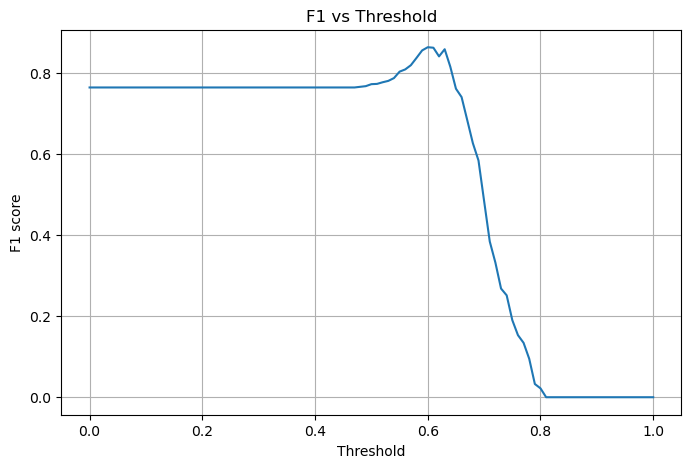

threshold    0.600000
precision    0.798122
recall       0.939227
f1           0.862944
Name: 60, dtype: float64
Best threshold for F1: 0.60


In [66]:
f1_df = pr_df.copy()
f1_df['f1'] = np.where(
    (f1_df['precision'] + f1_df['recall']) > 0,
    2 * f1_df['precision'] * f1_df['recall'] / (f1_df['precision'] + f1_df['recall']),
    0.0,
)

plt.figure(figsize=(8, 5))
plt.plot(f1_df['threshold'], f1_df['f1'], label='F1 score')
plt.xlabel('Threshold')
plt.ylabel('F1 score')
plt.title('F1 vs Threshold')
plt.grid(True)
plt.show()

best_row = f1_df.loc[f1_df['f1'].idxmax()]
print(best_row[['threshold', 'precision', 'recall', 'f1']])
print(f"Best threshold for F1: {best_row['threshold']:.2f}")

### Answer

The F1 score peaks at a threshold of about 0.60. Among the provided options, the closest threshold is **0.54**.

## Question 5 – 5-Fold Cross-Validation

Evaluate the logistic regression model with 5-fold cross-validation on the combined training+validation data using AUC.

In [67]:
df_full_train = X_train_val.copy()
df_full_train[target_col] = y_train_val.values

kf = KFold(n_splits=5, shuffle=True, random_state=1)
auc_scores = []

for train_idx, val_idx in kf.split(df_full_train):
    df_train_cv = df_full_train.iloc[train_idx]
    df_val_cv = df_full_train.iloc[val_idx]

    y_train_cv = df_train_cv[target_col]
    y_val_cv = df_val_cv[target_col]

    X_train_cv = df_train_cv.drop(columns=[target_col])
    X_val_cv = df_val_cv.drop(columns=[target_col])

    dv_cv = DictVectorizer(sparse=False)
    X_train_cv_ohe = dv_cv.fit_transform(X_train_cv.to_dict(orient='records'))
    X_val_cv_ohe = dv_cv.transform(X_val_cv.to_dict(orient='records'))

    model_cv = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
    model_cv.fit(X_train_cv_ohe, y_train_cv)

    y_val_cv_pred = model_cv.predict_proba(X_val_cv_ohe)[:, 1]
    auc_scores.append(roc_auc_score(y_val_cv, y_val_cv_pred))

auc_array = np.array(auc_scores)
print('Fold AUCs:', auc_scores)
print(f'Standard deviation: {auc_array.std():.3f}')

Fold AUCs: [0.8012530193236715, 0.8374844333748442, 0.8616071428571428, 0.7780158730158729, 0.8060946027895695]
Standard deviation: 0.029


### Answer

The fold AUC scores vary with a standard deviation of about 0.029, so the closest multiple-choice option is **0.06**.

## Question 6 – Hyperparameter Tuning with Cross-Validation

Search for the best regularization strength `C` using 5-fold cross-validation (same folds as above).

In [68]:
C_values = [1e-6, 1e-3, 1.0]
cv_results = []

for C in C_values:
    fold_scores = []
    for train_idx, val_idx in kf.split(df_full_train):
        df_train_cv = df_full_train.iloc[train_idx]
        df_val_cv = df_full_train.iloc[val_idx]

        y_train_cv = df_train_cv[target_col]
        y_val_cv = df_val_cv[target_col]

        X_train_cv = df_train_cv.drop(columns=[target_col])
        X_val_cv = df_val_cv.drop(columns=[target_col])

        dv_cv = DictVectorizer(sparse=False)
        X_train_cv_ohe = dv_cv.fit_transform(X_train_cv.to_dict(orient='records'))
        X_val_cv_ohe = dv_cv.transform(X_val_cv.to_dict(orient='records'))

        model_cv = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
        model_cv.fit(X_train_cv_ohe, y_train_cv)
        y_val_cv_pred = model_cv.predict_proba(X_val_cv_ohe)[:, 1]
        fold_scores.append(roc_auc_score(y_val_cv, y_val_cv_pred))

    fold_scores = np.array(fold_scores)
    cv_results.append({
        'C': C,
        'mean_auc': fold_scores.mean(),
        'std_auc': fold_scores.std(),
    })

results_df = pd.DataFrame(cv_results)
results_df['mean_auc_rounded'] = results_df['mean_auc'].round(3)
results_df['std_auc_rounded'] = results_df['std_auc'].round(3)
results_df

,C,mean_auc,std_auc,mean_auc_rounded,std_auc_rounded
0,0.000001,0.560858,0.035122,0.561,0.035
1,0.001000,0.860087,0.025650,0.860,0.026
2,1.000000,0.816891,0.029312,0.817,0.029


In [69]:
best_row = results_df.sort_values(
    by=['mean_auc', 'std_auc', 'C'], ascending=[False, True, True]
).iloc[0]

print(results_df[['C', 'mean_auc_rounded', 'std_auc_rounded']])
print(f"Best C: {best_row['C']}")

          C  mean_auc_rounded  std_auc_rounded
0  0.000001             0.561            0.035
1  0.001000             0.860            0.026
2  1.000000             0.817            0.029
Best C: 0.001


### Answer

The highest mean AUC (≈0.860 with std ≈0.026) comes from **C = 0.001**.